In [247]:
import requests
import numpy as np
import pandas as pd

from tqdm import tqdm

In [248]:
df_train = pd.read_csv("../data/train.csv")
df_test = pd.read_csv("../data/test.csv")
pre_test = pd.read_csv("../data/pre_test.csv")

/tmp/ipykernel_542535/1537677476.py:1: DtypeWarning: Columns (16,17,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv("../data/train.csv")


In [206]:
df_test[['본번', '부번']] = df_test[['본번', '부번']].astype(int)

In [207]:
api_key = '' # kakao rest_api key

In [208]:
def get_coordinates_with_fallback(region, bonbun, bubun, api_key):
    """
    주소를 단계적으로 축소해가며 좌표를 검색합니다.
    
    Parameters:
    - region (str): 행정구역 (시/도 + 구/군 + 읍/면/동)
    - bonbun (int): 본번
    - bubun (int): 부번
    - api_key (str): Kakao Maps REST API 키
    
    Returns:
    - tuple: (latitude, longitude) 또는 None (오류 시)
    """
    # 주소를 축소하는 순서대로 리스트 생성
    addresses = []
    if bubun > 0:
        addresses.append(f"{region} {bonbun}-{bubun}")  # 본번과 부번 포함
    addresses.append(f"{region} {bonbun}")  # 본번만 포함
    addresses.append(region)  # 행정구역만 포함

    url = "https://dapi.kakao.com/v2/local/search/address.json"
    headers = {"Authorization": f"KakaoAK {api_key}"}

    for address in addresses:
        params = {"query": address}
        try:
            response = requests.get(url, headers=headers, params=params)
            response.raise_for_status()
            result = response.json()

            if result["documents"]:
                # 첫 번째 결과의 좌표 반환
                x = result["documents"][0]["x"]  # 경도
                y = result["documents"][0]["y"]  # 위도
                # print(f"주소 검색 성공: {address}")
                return float(y), float(x)
            else:
                # print(f"주소를 찾을 수 없습니다: {address}")
                pass

        except requests.exceptions.HTTPError as e:
            print(f"HTTP 오류 발생: {e}")
        except Exception as e:
            print(f"기타 오류 발생: {e}")
    
    # 모든 시도가 실패하면 None 반환
    return None

In [209]:
df_test[['new_x', 'new_y']] = ''

In [210]:
API_KEY = api_key

In [211]:
for i in tqdm(range(len(df_test))):
    # 본번과 부번을 사용한 예제
    region = df_test['시군구'][i]
    bonbun = df_test['본번'][i]
    bubun = df_test['부번'][i]

    coordinates = get_coordinates_with_fallback(region, bonbun, bubun, API_KEY)

    if coordinates:
        df_test.loc[i, ['new_x', 'new_y']] = coordinates[0], coordinates[1]
    else:
        print("좌표를 가져오는 데 실패했습니다.")

100%|██████████| 9272/9272 [09:36<00:00, 16.08it/s]


In [212]:
df_test[['new_x', 'new_y']].isnull().sum()

new_x    0
new_y    0
dtype: int64

array([[<Axes: title={'center': '좌표X'}>, <Axes: title={'center': '좌표Y'}>]],
      dtype=object)

/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Glyph 51340 (\N{HANGUL SYLLABLE JWA}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Glyph 54364 (\N{HANGUL SYLLABLE PYO}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51340 (\N{HANGUL SYLLABLE JWA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 54364 (\N{HANGUL SYLLABLE PYO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


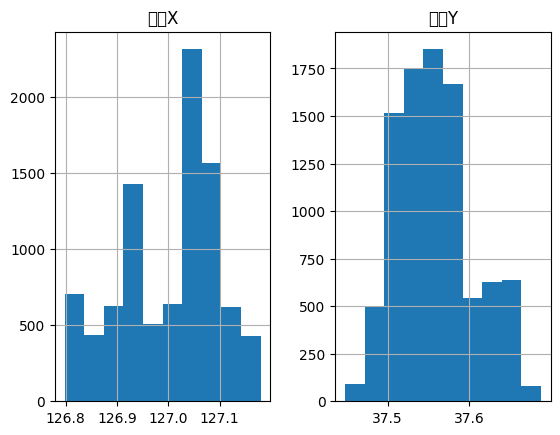

In [213]:
pre_test[['좌표X', '좌표Y']].hist()

In [218]:
df_test['new_x'] = df_test['new_x'].astype('float')
df_test['new_y'] = df_test['new_y'].astype('float')

array([[<Axes: title={'center': 'new_x'}>,
        <Axes: title={'center': 'new_y'}>]], dtype=object)

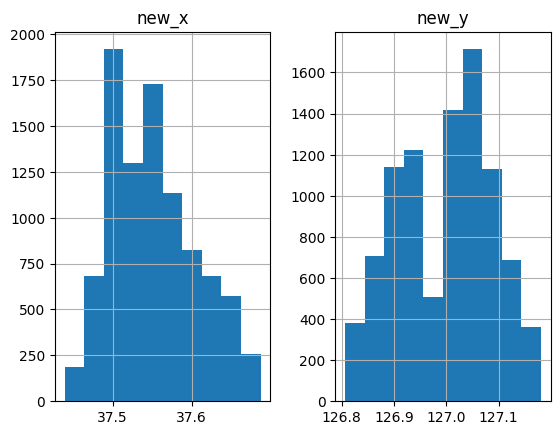

In [219]:
df_test[['new_x', 'new_y']].hist()

In [221]:
pre_test[['좌표X', '좌표Y']] = df_test[['new_x', 'new_y']]

In [223]:
pre_test.to_csv("../data/pre_test_01.csv", index=False)

---

In [249]:
pre_train = pd.read_csv("../data/pre_train.csv")

In [250]:
len(pre_train), len(df_train)

(1116621, 1118822)

In [251]:
nan_index = df_train['아파트명'].dropna(axis=0).index

In [254]:
df_train = df_train.iloc[nan_index]

In [255]:
df_train.reset_index(drop=True, inplace=True)

In [256]:
len(pre_train), len(df_train)

(1116621, 1116696)

In [257]:
nan_index = df_train[df_train[['번지', '본번','부번']].isna().all(axis=1)].index

In [258]:
len(nan_index)

75

In [260]:
df_train.drop(nan_index, inplace=True)

/tmp/ipykernel_542535/3889652446.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(nan_index, inplace=True)


In [261]:
df_train.reset_index(drop=True, inplace=True)

In [262]:
len(pre_train), len(df_train)

(1116621, 1116621)

In [263]:
df_train[['new_x', 'new_y']] = ''

/tmp/ipykernel_542535/2517129124.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[['new_x', 'new_y']] = ''
/tmp/ipykernel_542535/2517129124.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[['new_x', 'new_y']] = ''


In [264]:
df_train[['본번', '부번']] = df_train[['본번', '부번']].astype(int)

/tmp/ipykernel_542535/1103116773.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[['본번', '부번']] = df_train[['본번', '부번']].astype(int)


In [266]:
unique_addresses = df_train[['시군구', '본번', '부번']].drop_duplicates()
unique_addresses

,시군구,본번,부번
0,서울특별시 강남구 개포동,658,1
12,서울특별시 강남구 개포동,652,0
25,서울특별시 강남구 개포동,12,2
38,서울특별시 강남구 개포동,141,0
204,서울특별시 강남구 개포동,187,0
...,...,...,...
1076698,서울특별시 강남구 역삼동,763,0
1084864,서울특별시 구로구 구로동,807,39
1102856,서울특별시 서초구 반포동,16,1
1103228,서울특별시 서초구 서초동,1686,4


In [268]:
tqdm.pandas() 

In [269]:
unique_addresses['coordinates'] = unique_addresses.progress_apply(
    lambda row: get_coordinates_with_fallback(row['시군구'], row['본번'], row['부번'], API_KEY), axis=1
)

100%|██████████| 8661/8661 [10:04<00:00, 14.33it/s]


In [270]:
# 원본 데이터와 병합
df_train = df_train.merge(unique_addresses, on=['시군구', '본번', '부번'], how='left')

In [302]:
df_train['new_x'] = df_train['coordinates'].astype('str').str.split(',', expand=True)[0].str.split('(', expand=True)[1]
df_train['new_y'] = df_train['coordinates'].astype('str').str.split(',', expand=True)[1].str.split(')', expand=True)[0]

In [305]:
df_train[['new_x', 'new_y']].isnull().sum()

new_x    0
new_y    0
dtype: int64

In [307]:
df_train[['new_x', 'new_y']] = df_train[['new_x', 'new_y']].astype('float')

array([[<Axes: title={'center': 'new_x'}>,
        <Axes: title={'center': 'new_y'}>]], dtype=object)

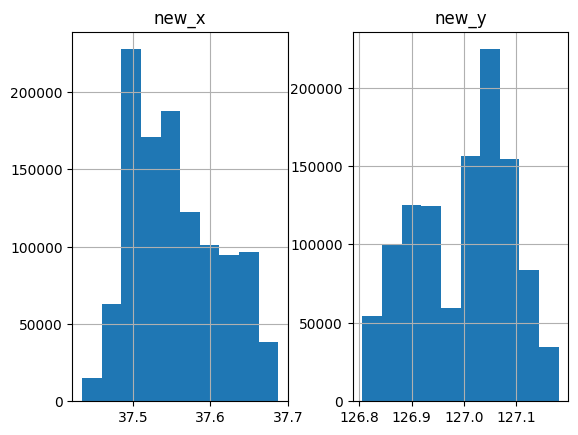

In [308]:
df_train[['new_x', 'new_y']].hist()

In [309]:
pre_train[['좌표X', '좌표Y']] = df_train[['new_x', 'new_y']]

In [310]:
pre_train.to_csv("../data/pre_train_01.csv", index=False)

---

In [313]:
pre_train.head(2)

,동,강남구,강동구,강북구,강서구,관악구,광진구,구로구,금천구,노원구,...,전체동수,전체세대수,연면적,주거전용면적,관리비부과면적,전용면적별세대현황합,건축면적,주차대수,좌표X,좌표Y
0,319,1,0,0,0,0,0,0,0,0,...,8.0,270.0,22637.0,20204.0,22637.0,520.0,4858.0,262.0,37.476156,127.057212
1,319,1,0,0,0,0,0,0,0,0,...,8.0,270.0,22637.0,20204.0,22637.0,520.0,4858.0,262.0,37.476156,127.057212


In [314]:
pre_test.head(2)

,동,강남구,강동구,강북구,강서구,관악구,광진구,구로구,금천구,노원구,...,전체동수,전체세대수,연면적,주거전용면적,관리비부과면적,전용면적별세대현황합,건축면적,주차대수,좌표X,좌표Y
0,319,1,0,0,0,0,0,0,0,0,...,8.0,270.0,22637.0,20204.0,22637.0,520.0,4858.00,262.0,127.057210,37.476763
1,319,1,0,0,0,0,0,0,0,0,...,2.0,232.0,44951.0,24878.0,31174.0,696.0,2724.46,305.0,127.056394,37.484892


---

In [354]:
from scipy.spatial.distance import cdist

subway = pd.read_csv("../data/subway_feature.csv")

In [355]:
subway.head(2)

,역사_ID,역사명,호선,위도,경도
0,9996,미사,5호선,37.560927,127.193877
1,9995,강일,5호선,37.557490,127.175930


In [356]:
# 거리 계산 (유클리드 거리 사용)
distances = cdist(pre_train[['좌표X', '좌표Y']], subway[['위도', '경도']], metric='euclidean')

# 각 행에서 가장 가까운 인덱스와 거리 추출
closest_indices = np.argmin(distances, axis=1)
closest_distances = np.min(distances, axis=1)

# 결과를 새로운 데이터프레임에 저장
results = pd.DataFrame({
    'pre_train_index': range(len(pre_train)),
    'subway_index': closest_indices,
    'distance': closest_distances
})

In [357]:
pre_train['subway_distance'] = results['distance']

In [358]:
results

,pre_train_index,subway_index,distance
0,0,619,0.010809
1,1,619,0.010809
2,2,619,0.010809
3,3,619,0.010809
4,4,619,0.010809
...,...,...,...
1116616,1116616,316,0.011771
1116617,1116617,316,0.011771
1116618,1116618,316,0.011771
1116619,1116619,316,0.011771


In [362]:
subway_selected = subway[['역사_ID','역사명', '호선']]

In [363]:
subway_indices = results['subway_index'].values

In [365]:
pre_train[['역사ID', '역사명', '호선']] = subway_selected.iloc[subway_indices].values

In [369]:
pre_train['역사ID'] = pre_train['역사ID'].astype('int')

In [371]:
pre_train.to_csv("../data/pre_train_02.csv", index=False)

In [372]:
subway = pd.read_csv("../data/subway_feature.csv")

# 거리 계산 (유클리드 거리 사용)
distances = cdist(pre_test[['좌표X', '좌표Y']], subway[['위도', '경도']], metric='euclidean')

# 각 행에서 가장 가까운 인덱스와 거리 추출
closest_indices = np.argmin(distances, axis=1)
closest_distances = np.min(distances, axis=1)

# 결과를 새로운 데이터프레임에 저장
results = pd.DataFrame({
    'pre_test_index': range(len(pre_test)),
    'subway_index': closest_indices,
    'distance': closest_distances
})

In [373]:
pre_test['subway_distance'] = results['distance']

In [374]:
subway_selected = subway[['역사_ID','역사명', '호선']]
subway_indices = results['subway_index'].values
pre_test[['역사ID', '역사명', '호선']] = subway_selected.iloc[subway_indices].values
pre_test['역사ID'] = pre_test['역사ID'].astype('int')
pre_test.to_csv("../data/pre_test_02.csv", index=False)

---

In [376]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
pre_train['is_test'] = 0
pre_test['is_test'] = 1
concat = pd.concat([pre_train, pre_test])     # 하나의 데이터로 만들어줍니다.

In [379]:
concat.reset_index(drop=True, inplace=True)

In [383]:
from sklearn.preprocessing import LabelEncoder

In [384]:
le = LabelEncoder()

In [386]:
concat['역사명'] = le.fit_transform(concat['역사명'])

In [390]:
le = LabelEncoder()

In [391]:
concat['호선'] = le.fit_transform(concat['호선'])

In [392]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
pre_train = concat.query('is_test==0')
pre_test = concat.query('is_test==1')

In [393]:
len(pre_train) , len(pre_test)

(1116621, 9272)

In [394]:
# 이제 is_test 칼럼은 drop해줍니다.
pre_train.drop(['is_test'], axis = 1, inplace=True)
pre_test.drop(['is_test'], axis = 1, inplace=True)
print(pre_train.shape, pre_test.shape, y.shape)

(1116621, 92) (9272, 92) (1116621, 1)


/tmp/ipykernel_542535/1025557389.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_train.drop(['is_test'], axis = 1, inplace=True)
/tmp/ipykernel_542535/1025557389.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_test.drop(['is_test'], axis = 1, inplace=True)


In [395]:
pre_train.to_csv("../data/pre_train_03.csv", index=False)
pre_test.to_csv("../data/pre_test_03.csv", index=False)